# Assignment 5 MidTerm 3 ~ Paul M. Magos 588669

In [2]:
import tensorflow as tf
import pandas as pd
import keras as K
import myutils 
import pickle
import os
%load_ext autoreload
%reload_ext autoreload
%autoreload 2 


SubjectFlags = [True, False]
MAX_TEXT_LENS = [500]
embedding_size = 50


INPUT_LEN = MAX_TEXT_LENS[0] + 100

# Paths to the data and models folders
tokenizers_path = './tokenizers'
our_path_LSTM = './ourModelsLSTM'
keras_path = './ktModels'
our_path = './ourModels'
             
# Kind of training sets
ModelsNames = ['Balanced', 'UnbalancedReal', 'UnbalancedFake']
# All the combinations of models with the different parameters 
# We will use these to create a different obejct of each thing we need for each model
ModelsNames = [name+'_'+str(MAX_TEXT_LEN)+'_'+str(subFlag) for name in ModelsNames for subFlag in SubjectFlags for MAX_TEXT_LEN in MAX_TEXT_LENS]

TrainOurModels = {}
TrainKerasModels = {}
TrainLSTMModels = {}

LoadOurModels = {}
LoadKerasModels = {}
LoadLSTMModels = {}

SaveOurModels = {}
SaveKerasModels = {}
SaveLSTMModels = {}

# Check if the models exist we load them, if not, we will train them
for kind in ModelsNames:
    TrainOurModels[kind] = False
    TrainLSTMModels[kind] = False
    TrainKerasModels[kind] = False
    LoadOurModels[kind] = True
    LoadKerasModels[kind] = True
    LoadLSTMModels[kind] = True
    SaveOurModels[kind] = False
    SaveKerasModels[kind] = False
    SaveLSTMModels[kind] = False
    if not os.path.exists(f'{our_path}/{kind}.h5'):
        TrainOurModels[kind] = True    
        LoadOurModels[kind] = False
    if not os.path.exists(f'{our_path_LSTM}/{kind}.h5'):
        TrainLSTMModels[kind] = True        
        LoadLSTMModels[kind] = False
    if not os.path.exists(f'{keras_path}/{kind}'):
        TrainKerasModels[kind] = True
        LoadLSTMModels[kind] = False

    
# Remove comment if want to train a model from scratch anyway or by changing the flag to False to not train it at all if not present
# (Will be trained if not present and flag will be true True)

# TrainOurModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = True
# TrainOurModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = True
# TrainOurModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = True
# TrainOurModels[f'Balanced_{MAX_TEXT_LENS[0]}_False'] = True
# TrainOurModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_False'] = True
# TrainOurModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_False'] = True

# TrainKerasModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = True
# TrainKerasModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = True
# TrainKerasModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = True
# TrainKerasModels[f'Balanced_{MAX_TEXT_LENS[0]}_False'] = True
# TrainKerasModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_False'] = True
# TrainKerasModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_False'] = True

TrainLSTMModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = False
TrainLSTMModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = False
TrainLSTMModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = False
# TrainLSTMModels[f'Balanced_{MAX_TEXT_LENS[0]}_False'] = True
# TrainLSTMModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_False'] = True
# TrainLSTMModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_False'] = True

# Remove the comment if you don't want to load a model

# LoadOurModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = False
# LoadOurModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = False
# LoadOurModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = False
LoadKerasModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = False
LoadKerasModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = False
LoadKerasModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = False
# LoadLSTMModels[f'Balanced_{MAX_TEXT_LENS[0]}_True'] = False
# LoadLSTMModels[f'UnbalancedReal_{MAX_TEXT_LENS[0]}_True'] = False
# LoadLSTMModels[f'UnbalancedFake_{MAX_TEXT_LENS[0]}_True'] = False

allNews = myutils.initDF()

print(ModelsNames)
# tf.config.list_logical_devices()

Loading data from processed file
['Balanced_500_True', 'Balanced_500_False', 'UnbalancedReal_500_True', 'UnbalancedReal_500_False', 'UnbalancedFake_500_True', 'UnbalancedFake_500_False']


* We set the models to compute and the ones to load if already computed.
* Then we init the dataset by loading all the data. 
* We also set all the paths to the data and the models. 


## Create balanced dataset and create train, validation and test sets

In [3]:
from sklearn.model_selection import train_test_split 
# Pop the label column
balancedLabels = allNews.pop('label')

x_train = {}
y_train = {}
x_test = {}
x_val = {}


for kind in ModelsNames:
    if kind.startswith('Balanced'):
        # Split dataset into train, validation and test (it's equal for val and test for each model, only the train is different)
        x_train[kind], x_test[kind], y_train[kind], y_test = train_test_split(allNews.copy(), balancedLabels.copy(), test_size=0.1, train_size=0.9, shuffle=False)
        x_train[kind], x_val[kind], y_train[kind], y_val = train_test_split(x_train[kind].copy(), y_train[kind].copy(), test_size=0.2222, train_size=0.7778, shuffle=False)
        # Check how many samples of each kind we have in the training set
        print(kind, '\n', y_train[kind].value_counts())

Balanced_500_True 
 1    16440
0    14989
Name: label, dtype: int64
Balanced_500_False 
 1    16440
0    14989
Name: label, dtype: int64


### We split the data into train, validation and test sets. 
* The training set created in this cell will be also the Balanced training dataset.
* The validation and test sets will be the same for all the models indipendentlly from the training dataset used.

# Create unbalanced dataset
## Only half fake news

In [4]:
# FakeNews label = 1
for kind in ModelsNames:
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    if kind.startswith('UnbalancedFake'):
        x_train[kind], y_train[kind] = myutils.unbalance(x_train['Balanced'+typee].copy(), y_train['Balanced'+typee].copy(), 1, force=True)
        x_val[kind] = x_val['Balanced'+typee].copy()
        print(f"{kind}\n {y_train[kind].value_counts()}")


UnbalancedFake_500_True
 0    14989
1     8220
Name: label, dtype: int64
UnbalancedFake_500_False
 0    14989
1     8220
Name: label, dtype: int64


### We pick the Balanced training set and we remove from it 50 % of the fake news.

## Only half real news

In [5]:
# RealNews label = 0
for kind in ModelsNames:
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    if kind.startswith('UnbalancedReal'):
        x_train[kind], y_train[kind] = myutils.unbalance(x_train['Balanced'+typee].copy(), y_train['Balanced'+typee].copy(), 0, force=True)
        x_val[kind] = x_val['Balanced'+typee].copy()
        print(f"{kind}\n {y_train[kind].value_counts()}")

UnbalancedReal_500_True
 1    16440
0     7495
Name: label, dtype: int64
UnbalancedReal_500_False
 1    16440
0     7495
Name: label, dtype: int64


### Same things for the Real news, we pick the Balanced training set and we remove from it 50 % of the real news.

## Dict Index

### Let's vectorize the texts in the news, to have a dict index of the words. The maximum number of words is set to 10000.
* For each training set we create a dict index, different since each of the training sets is different so it will have different vectorization when used on the validation and test sets.

In [6]:
from keras.preprocessing.text import Tokenizer

vectorizer = {}
vocab_size = {}

for kind in ModelsNames:
    if os.path.exists(f'{tokenizers_path}/{kind}_vectorizer.pickle'):
        with open(f'{tokenizers_path}/{kind}_vectorizer.pickle', 'rb') as handle:
            vectorizer[kind] = pickle.load(handle)
    else:
        # Create a vectorizer for each dataset
        vectorizer[kind] = Tokenizer(num_words=10000)
        
        # Fit the vectorizer to the data in each dataset8
        vectorizer[kind].fit_on_texts(x_train[kind].title)
        vectorizer[kind].fit_on_texts(x_train[kind].text)
        vectorizer[kind].fit_on_texts(x_train[kind].subject)
        
        with open(f'{tokenizers_path}/{kind}_vectorizer.pickle', 'wb') as handle:
            pickle.dump(vectorizer[kind], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save the vocab size for each dataset
    vocab_size[kind] = len(vectorizer[kind].word_index) + 2

### Text conversion

### We now convert the text, title and subject of the news in the training and validation sets to sequences of integers, using the dict index created before.

In [7]:

from keras_preprocessing.sequence import pad_sequences

def convert(df, kind, columns = ['title', 'text', 'subject']):
    for column in columns:
        df[column] = vectorizer[kind].texts_to_sequences(df[column])
    return df

# Convert the data in each dataset
for kind in ModelsNames:
    x_train[kind] = convert(x_train[kind].copy(), kind)
    # Convert validation set
    # Validation set is equal for all the tests
    x_val[kind] = convert(x_val[kind].copy(), kind)

In [8]:
for kind in ModelsNames:
    
    print(kind, x_train[kind].shape)

Balanced_500_True (31429, 4)
Balanced_500_False (31429, 4)
UnbalancedReal_500_True (23935, 4)
UnbalancedReal_500_False (23935, 4)
UnbalancedFake_500_True (23209, 4)
UnbalancedFake_500_False (23209, 4)


# Text Padding/Truncation for Normalization

* Based on the initial settings for each kind of training set, we create a representation of the news that will have or not the subject in it. This is because as we'll see it's important in some cases. We have in fact the SubjectFlag in the first cell of the notebook, that is set to True or False for each model.
* We pad the sequences of integers to have them all of the same length, truncating the longer ones and padding the shorter ones with zeros. 
* We concatenate the Text, Title and subject (if the subject is set to be True for the specific model) of the dataset to have a single sequence of integers for each news. 
- (We considered in the conception of this method the the date as well, but it was worthless in the end)

In [9]:
import numpy as np


def Normalize(df, columns = ['title', 'text'], subject = True, MAX_LEN = MAX_TEXT_LENS[0], PaddingKind = 'post'):
    tmp = {}    
    for column in columns:
        tmp[column] = pad_sequences(df[column].tolist(), maxlen=(MAX_LEN if column == 'text' else 100), padding=PaddingKind)
    if subject:
        tmp['subject'] = pad_sequences(df['subject'].tolist(), maxlen=2, padding=PaddingKind)
    out = np.empty((len(tmp['text']), INPUT_LEN + (2 if subject else 0)))
    for i in range(len(tmp['text'])):
        if subject:
            out[i] = np.append(np.append(tmp['text'][i], tmp['title'][i]), tmp['subject'][i])
        else:
            out[i] = np.append(tmp['text'][i], tmp['title'][i])
    return out

for kind in ModelsNames:
    sub = True if kind.split('_')[2] == 'True' else False
    # Read Training Data
    x_train[kind] = Normalize(x_train[kind].copy(),  subject = sub)
    # Convert to numpy arrays the labels for Balanced training dataset
    y_train[kind] = np.array(y_train[kind].copy())
    x_val[kind] = Normalize(x_val[kind].copy(), subject = sub)
    
# Convert to numpy arrays the labels for Validation set
y_val = np.array(y_val)

for kind in ModelsNames:
    out = '' if kind.split('_')[2] != 'True' else 'out'
    # Print shape of data and label for each Training Set
    print('\n')
    print(f'Shape of data and label for {kind} with{out} news argument training set:', x_train[kind].shape, y_train[kind].shape)
    print(f'Shape of data and label for {kind} with{out} news argument Validation set:', x_val[kind].shape, y_val.shape)
    



Shape of data and label for Balanced_500_True without news argument training set: (31429, 602) (31429,)
Shape of data and label for Balanced_500_True without news argument Validation set: (8979, 602) (8979,)


Shape of data and label for Balanced_500_False with news argument training set: (31429, 600) (31429,)
Shape of data and label for Balanced_500_False with news argument Validation set: (8979, 600) (8979,)


Shape of data and label for UnbalancedReal_500_True without news argument training set: (23935, 602) (23935,)
Shape of data and label for UnbalancedReal_500_True without news argument Validation set: (8979, 602) (8979,)


Shape of data and label for UnbalancedReal_500_False with news argument training set: (23935, 600) (23935,)
Shape of data and label for UnbalancedReal_500_False with news argument Validation set: (8979, 600) (8979,)


Shape of data and label for UnbalancedFake_500_True without news argument training set: (23209, 602) (23209,)
Shape of data and label for Unba

# Embedding

- We now load an embedding of words, that will be used to create the embedding matrix for the Embedding layer of the models. 
- Each model will have its own embedding matrix, since the dict index is different for each training set. 

In [10]:
import numpy as np
embedding_dict = {}
with open(f"./embeddings/glove.6B.{embedding_size}d.txt") as f:
    for line in f:
        words, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embedding_dict[words] = coefficients

### Embedding Matrix

- We create the embedding matrix for each training set, using the embedding loaded before.

In [11]:
import numpy as np
embedding_dim = embedding_size

embedding_matrix = {}

for kind in ModelsNames:
    embedding_matrix[kind] = np.zeros((vocab_size[kind], embedding_dim))
    for word, i in vectorizer[kind].word_index.items():
        embedding_vector = vectorizer[kind].word_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[kind][i] = embedding_vector
    # Print all embedding matrix shapes
    print(kind, embedding_matrix[kind].shape)

Balanced_500_True (126648, 50)
Balanced_500_False (126648, 50)
UnbalancedReal_500_True (112862, 50)
UnbalancedReal_500_False (112911, 50)
UnbalancedFake_500_True (107083, 50)
UnbalancedFake_500_False (107499, 50)


# Tensorflow embedding layer

- Then we create the embedding layer for each model, using the embedding matrix created before.

In [12]:
embedding_layer = {}
for kind in ModelsNames:
    sub = kind.split('_')[2] == 'True'
    embedding_layer[kind] = K.layers.Embedding(vocab_size[kind], 
                                                                embedding_dim, 
                                                                embeddings_initializer= K.initializers.Constant(
                                                                    embedding_matrix[kind]), 
                                                                trainable=False, 
                                                                input_length=INPUT_LEN + (2 if sub else 0))
        
GLOBAL_KIND = 'Balanced'
def getEmbeddingLayer(kind):
    return embedding_layer[kind]

In [13]:
for kind in ModelsNames:
    print(kind, x_train[kind].shape,  y_train[kind].shape)
    print(kind, x_val[kind].shape, y_val.shape)

Balanced_500_True (31429, 602) (31429,)
Balanced_500_True (8979, 602) (8979,)
Balanced_500_False (31429, 600) (31429,)
Balanced_500_False (8979, 600) (8979,)
UnbalancedReal_500_True (23935, 602) (23935,)
UnbalancedReal_500_True (8979, 602) (8979,)
UnbalancedReal_500_False (23935, 600) (23935,)
UnbalancedReal_500_False (8979, 600) (8979,)
UnbalancedFake_500_True (23209, 602) (23209,)
UnbalancedFake_500_True (8979, 602) (8979,)
UnbalancedFake_500_False (23209, 600) (23209,)
UnbalancedFake_500_False (8979, 600) (8979,)


# Tensorflow CNN model

## Our Parameters CNN 
### For all the training sets we created a CNN with the following structure:

0. Embedding Layer
1. Layer 1: 128, kernel 4
2. Layer 2: MaxPooling 2 Strides
3. Layer 3: 64, kernel 4
4. Layer 4: MaxPooling 2 Strides
5. Layer 5: 32, kernel 4
6. Layer 6: MaxPooling 2 Strides
7. Layer 7: Flatten
8. Layer 8: Dense 256
9. Layer 9: Dense 1 (output) 

![Alt text](ourModels/images/UnbalancedFake_500_True.png)

In [14]:
import visualkeras

ourParamModels = {}
ourmodel_hist = {}

for kind in ModelsNames:
    if TrainOurModels[kind]:    
        ourParamModels[kind] = K.Sequential()
        ourParamModels[kind].add(embedding_layer[kind])
        ourParamModels[kind].add(K.layers.Conv1D(128, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(64, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(32, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Flatten())
        ourParamModels[kind].add(K.layers.Dense(256, activation='relu'))
        ourParamModels[kind].add(K.layers.Dense(1, activation='sigmoid'))
        
        ourParamModels[kind].compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        
        visualkeras.layered_view(ourParamModels[kind], scale_xy=0.8, draw_volume=True, legend=True, to_file=f'{our_path}/images/{kind}.png')
        print(f'Training {kind} model...')
        ourmodel_hist[kind] = ourParamModels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                mode='min',
                                                                                                patience=3,
                                                                                                min_delta=0.003,
                                                                                                restore_best_weights=True)])
        ourmodel_hist[kind] = ourmodel_hist[kind].history
        if SaveOurModels[kind]:
            ourParamModels[kind].save(f'{our_path}/{kind}.h5')
            with open(f'{our_path}/histories/{kind}_hist.hist', 'wb') as file_pi:
                pickle.dump(ourmodel_hist[kind], file_pi)
    else:
        if LoadOurModels[kind]:
            print(f'Loading {kind} model...:')
            if os.path.exists(f'{our_path}/{kind}.h5'):
                ourParamModels[kind] = tf.keras.models.load_model(f'{our_path}/{kind}.h5')
                print(f' {kind} our parameters model loaded')
                if os.path.exists(f'{our_path}/histories/{kind}_hist.hist'):
                    with open(f'{our_path}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        ourmodel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} our parameters model history loaded')
            else:
                print(f' {kind} our parameters model NOT found')
        else:
            print(f'Not loading {kind} our parameters model as per settings')

Loading Balanced_500_True model...:
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

 Balanced_500_True our parameters model loaded
 Balanced_500_True our parameters model history loaded
Loading Balanced_500_False model...:
 Balanced_500_False our parameters model loaded
 Balanced_500_False our parameters model history loaded
Loading UnbalancedReal_500_True model...:
 UnbalancedReal_500_True our parameters model loaded
 UnbalancedReal_500_True our parameters model history loaded
Loading UnbalancedReal_500_False model...:
 UnbalancedReal_500_False our parameters model loaded
 UnbalancedReal_500_False our parameters model history loaded
Loading UnbalancedFake_500_True model...:
 UnbalancedFake_500_True our parameters model loaded
 UnbalancedFake_500_True our parameters model history loaded
Loading UnbalancedFake_500_False model...:
 UnbalancedFake_500_False our parameters model loaded
 UnbalancedFake_500_False our parameters model history loaded


# Keras Tuner for Hyperparameter Tuning (Optional)

In [15]:
import keras_tuner
kerasmodels = {}
kerasmodel_hist = {}

Strides = [1, 2]
Kernels = [3, 4, 5]
Units = [128, 256]

Filters = {}
Filters[0] = [32, 64, 128]
Filters[1] = [32, 64, 128]
Filters[2] = [32, 64, 128]

BatchSizes = [64, 128, 256, 512]
LearningRates = [1e-2, 1e-3, 1e-4, 1e-5]

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        
        kerasmodel = K.Sequential()
        # Embedding Layer
        kerasmodel.add(getEmbeddingLayer(GLOBAL_KIND))
        # First Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_1_filters', Filters[0]), 
                                hp.Choice('conv_1_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_1_strides', Strides)))
        # Second Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_2_filters', Filters[1]), 
                                hp.Choice('conv_2_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_2_strides', Strides)))
        # Third Convolutional Layer
        kerasmodel.add(K.layers.Conv1D(hp.Choice('conv_3_filters', Filters[2]), 
                                hp.Choice('conv_3_kernel', Kernels), 
                                padding='same', activation='relu'))
        kerasmodel.add(K.layers.MaxPooling1D(hp.Choice('conv_3_strides', Strides)))
        # Flatten Layer
        kerasmodel.add(K.layers.Flatten())
        # Dense Layer
        kerasmodel.add(K.layers.Dense(hp.Choice('dense_1_units', Units), activation='relu'))
        # Classification Layer
        kerasmodel.add(K.layers.Dense(1, activation='sigmoid'))
        
        kerasmodel.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(
                    learning_rate = hp.Choice('learning_rate', LearningRates)
                ), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        return kerasmodel


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
            shuffle=True,
            epochs=15,
            batch_size=hp.Choice("batch_size",  BatchSizes),
            verbose=1,
            workers=-1,
            use_multiprocessing=True
            )

tuner = {}
for kind in ModelsNames:  
    # Finding best hyperparameters for each model
    print("Finding best hyperparameters for ", kind)
    GLOBAL_KIND = kind
    tuner[kind] = keras_tuner.GridSearch(
        MyHyperModel(),
        objective="val_accuracy",
        overwrite=TrainKerasModels[kind],
        directory=f"{keras_path}/{kind}",
        project_name=f"{kind}_CNN",
    )

    # if TrainModels[kind]:
    tuner[kind].search(x_train[kind], y_train[kind], 
                    validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=3,
                            min_delta=0.05,
                            restore_best_weights=True)])
    print(kind, tuner[kind].get_best_hyperparameters()[0].values)
    kerasmodels[kind] = tuner[kind].hypermodel.build(tuner[kind].get_best_hyperparameters()[0])
    if TrainKerasModels[kind]:
        kerasmodel_hist[kind] = kerasmodels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                    epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        mode='min',
        patience=3,
        min_delta=0.05,
        restore_best_weights=True)])
        kerasmodel_hist[kind] = kerasmodel_hist[kind].history
        if SaveKerasModels[kind]:
            kerasmodels[kind].save(f'{keras_path}/{kind}.h5')
            with open(f'{keras_path}/histories/{kind}_hist.hist', 'wb') as file_pi:
                pickle.dump(kerasmodel_hist[kind], file_pi)
    else:
        if LoadKerasModels[kind]:
            print(f'Loading {kind} keras model...:')
            if os.path.exists(f'{keras_path}/{kind}.h5'):
                kerasmodels[kind] = tf.keras.models.load_model(f'{keras_path}/{kind}.h5')
                print(f' {kind} keras model loaded')
                if os.path.exists(f'{keras_path}/histories/{kind}_hist.hist'):
                    with open(f'{keras_path}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        kerasmodel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} keras model history loaded')
            else:
                print(f' {kind} keras model NOT found')
        else:
            kerasmodels.pop(kind)
            print(f'Not loading {kind} keras model as per settings')

Finding best hyperparameters for  Balanced_500_True
INFO:tensorflow:Reloading Tuner from ./ktModels/Balanced_500_True/Balanced_500_True_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
Balanced_500_True {'conv_1_filters': 32, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Not loading Balanced_500_True keras model as per settings
Finding best hyperparameters for  Balanced_500_False
INFO:tensorflow:Reloading Tuner from ./ktModels/Balanced_500_False/Balanced_500_False_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
Balanced_500_False {'conv_1_filters': 128, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Loading Bal

## Keras tuner CNNs architectures
### Balanced withouth argument (as ours parameters)
![Alt text](ktModels/images/Balanced_500_False.png)
### All the other combinations (Balanced with argument, UnbalancedFake and UnbalancedReal with and without argument):
0. Embedding Layer
1. Layer 1: 32, kernel 4
2. Layer 2: MaxPooling 2 Strides
3. Layer 3: 64, kernel 4
4. Layer 4: MaxPooling 2 Strides
5. Layer 5: 32, kernel 4
6. Layer 6: MaxPooling 2 Strides
7. Layer 7: Flatten
8. Layer 8: Dense 256
9. Layer 9: Dense 1 (output)   
 
![Alt text](ktModels/images/UnbalancedReal_500_True.png)


 * SEEMS like keras has fount that as size of 32 for the first CNN layer is the best for all the datasets except the Balanced without the argument. Except we obatained better results with 128 as first layer size. This is probably due to the fact that the keras CNN stops before due to the early stopping callback and it doesn't choose our parameters since with less epochs the one with size 32 on first layer achieves better validation accuracy.
 * Training for 2 or 3 epochs more the 128 kind (like our) would led to better performances than the 32 kind. Still was not worth to try better callback settings since we knew the results of our parameters model. 

# Let's try LSTM


## Our Parameters LSTM (multi layer bidirectional LSTM)
### For all the training sets we created a LSTM with the following structure:
0. Embedding Layer
1. Layer 1: Bidirectional LSTM 128
2. Layer 2: Bidirectional LSTM 64
3. Layer 3: Bidirectional LSTM 32
4. Layer 4: Dense 64
5. Layer 5: Dropout 0.5
6. Layer 6: Dense 1 (output)

![Alt text](ourModelsLSTM/images/Balanced_500_False.png)

* We tried only the training sets without the argument since we knew that the best results were obtained with the argument. And the model trained on the Balanced dataset without the argument was the best one overall achieving 0.95 of validation accuracy.

In [16]:
import sys
ourParamLSTMModels = {}
ourLSTMModel_hist = {}

for kind in ModelsNames:
    if TrainLSTMModels[kind]:    
        ourParamLSTMModels[kind] = K.Sequential()
        ourParamLSTMModels[kind].add(embedding_layer[kind])
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)))
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)))
        ourParamLSTMModels[kind].add(K.layers.Bidirectional(tf.keras.layers.LSTM(32)))
        ourParamLSTMModels[kind].add(K.layers.Dense(64, activation='relu'))
        ourParamLSTMModels[kind].add(K.layers.Dropout(0.5))
        ourParamLSTMModels[kind].add(K.layers.Dense(1, activation='sigmoid'))
        
        ourParamLSTMModels[kind].compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        
        print(f'Training {kind} model...')
        ourLSTMModel_hist[kind] = ourParamLSTMModels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                mode='min',
                                                                                                patience=3,
                                                                                                min_delta=0.003,
                                                                                                restore_best_weights=True)])
        ourParamLSTMModels[kind] = ourParamLSTMModels[kind].history
        if SaveLSTMModels[kind]:
            ourParamLSTMModels[kind].save(f'{our_path_LSTM}/{kind}.h5')
            visualkeras.layered_view(ourParamLSTMModels[kind], scale_xy=0.8, draw_volume=True, legend=True, to_file=f'{our_path_LSTM}/images/{kind}.png')
            with open(f'{our_path_LSTM}/histories/{kind}_hist.hist', 'wb') as file_pi:
                pickle.dump(ourmodel_hist[kind], file_pi)
    else:
        if LoadLSTMModels[kind]:
            print(f'Loading {kind} LSTM model...:')
            if os.path.exists(f'{our_path_LSTM}/{kind}.h5'):
                ourParamLSTMModels[kind] = tf.keras.models.load_model(f'{our_path_LSTM}/{kind}.h5')
                print(f' {kind} LSTM model loaded')
                if os.path.exists(f'{our_path_LSTM}/histories/{kind}_hist.hist'):
                    with open(f'{our_path_LSTM}/histories/{kind}_hist.hist', 'rb') as file_pi:
                        ourLSTMModel_hist[kind] = pickle.load(file_pi)
                    print(f' {kind} LSTM model history loaded')
            else:
                print(f' {kind} LSTM model NOT found')
        else:
            print(f'Not loading {kind} LSTM model as per settings')

Not loading Balanced_500_True LSTM model as per settings
Loading Balanced_500_False LSTM model...:
 Balanced_500_False LSTM model loaded
 Balanced_500_False LSTM model history loaded
Not loading UnbalancedReal_500_True LSTM model as per settings
Loading UnbalancedReal_500_False LSTM model...:
 UnbalancedReal_500_False LSTM model loaded
 UnbalancedReal_500_False LSTM model history loaded
Not loading UnbalancedFake_500_True LSTM model as per settings
Loading UnbalancedFake_500_False LSTM model...:
 UnbalancedFake_500_False LSTM model loaded
 UnbalancedFake_500_False LSTM model history loaded


# Plot the history accuracy on training and validation sets for each model 

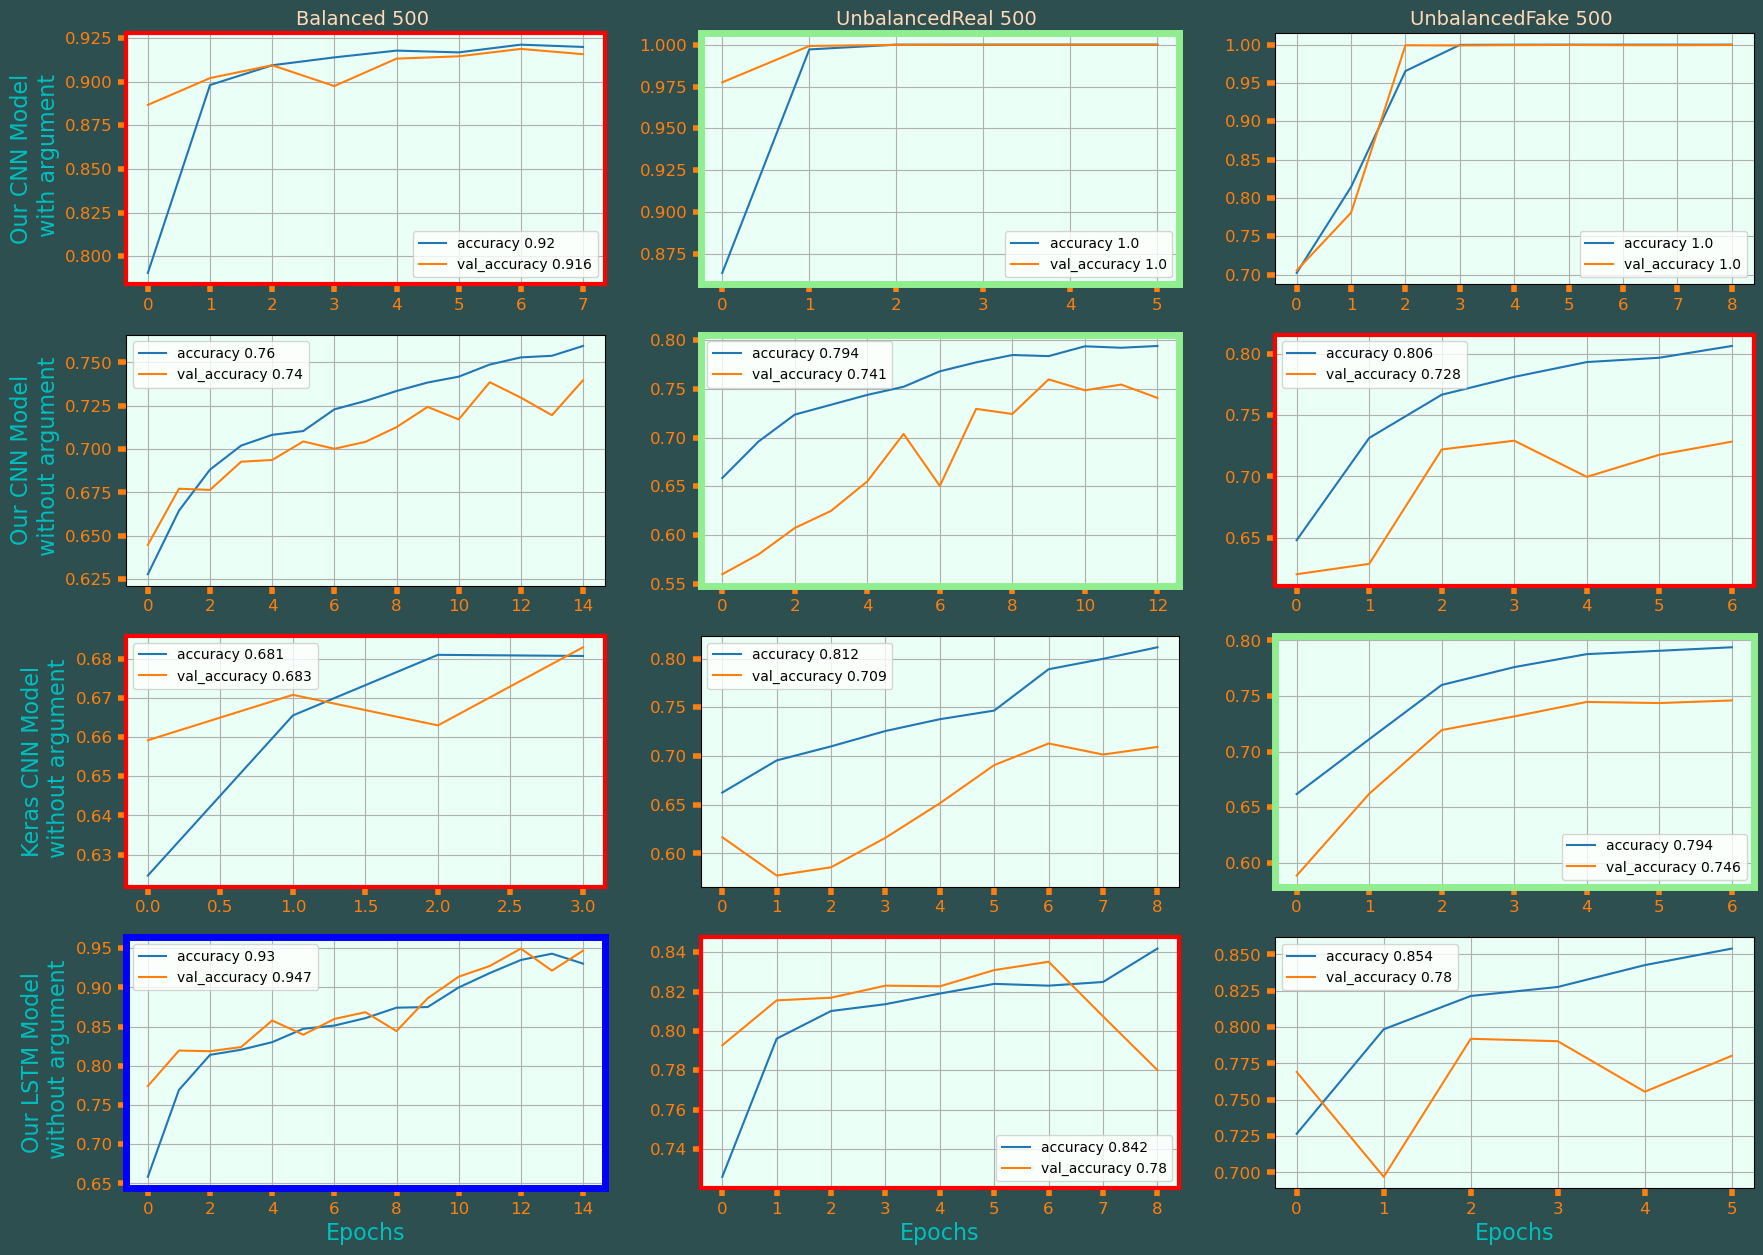

In [17]:
import matplotlib.pyplot as plt

plotstodo = int((len(ourParamLSTMModels.keys()) + len(kerasmodels.keys()) + len(ourParamModels.keys())) / 3)


# Plot a big image to compare the training history of each model, by enanching the best performing one for each kind
fig, ax = plt.subplots(plotstodo, 3, figsize=(21, 15), facecolor=(.18, .31, .31))

our_model_Rows = len(ourParamModels.keys()) // 3
keras_model_Rows = len(kerasmodels.keys()) // 3 + our_model_Rows
ourLSTM_model_Rows = len(ourParamLSTMModels.keys()) // 3 + keras_model_Rows

# Kind of metrics to plot
metrics = ['accuracy', 'val_accuracy']
# metrics = ['loss', 'val_loss']
# 
maxvalAcc = max([NN[kind][metrics[1]][-1] if kind.split('_')[2] == 'False' else 0 
                     for NN in [ourmodel_hist, kerasmodel_hist, ourLSTMModel_hist] 
                     for kind in NN.keys()])

i = 0
for NN in [ourmodel_hist, kerasmodel_hist, ourLSTMModel_hist]:
    NNKeys = list(NN.keys())
    NNKeys.sort(key=lambda s: s.split('_')[2],  reverse=True)
    
    for j, kind in enumerate(NNKeys):
        # Increment i axis if j reached a multiple of 3
        if j>0 and j%3 == 0:
            i += 1
        if i == 0:
            ax[i, j%3].set_title(kind.replace('_', ' ').replace('True', '').replace('False', ''), color='peachpuff', size=14)
        # Plot the accuracy and val_accuracy
        ax[i, j%3].plot(NN[kind][metrics[0]], label=metrics[0] + ' ' + str(round(NN[kind][metrics[0]][-1], 3)))
        ax[i, j%3].plot(NN[kind][metrics[1]], label = metrics[1] + ' ' + str(round(NN[kind][metrics[1]][-1], 3)))
        # plot the legend
        ax[i, j%3].legend()
        # plot the grid
        ax[i, j%3].grid()
        ax[i, j%3].tick_params(labelcolor='tab:orange', labelsize='large', width=4, length=6, color='tab:orange')
        # print the name of the model on the left of each row
        ax[i, j%3].set_facecolor('#eafff5')
        # Remove x label for all but the last row
        if i == ourLSTM_model_Rows - 1:
            ax[i, j%3].set_xlabel('Epochs', color='c', size=16)

        df_index = i
       
        if i < our_model_Rows:
            if j%3 == 0 :
                ax[i, j%3].set_ylabel('Our CNN Model\n' + kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument'), color='c', size=16)
        elif i < keras_model_Rows:
            if j%3 == 0 :
                ax[i, j%3].set_ylabel('Keras CNN Model\n' + kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument'), color='c', size=16)
            df_index = i-our_model_Rows
        else:
            if j%3 == 0 :
                ax[i, j%3].set_ylabel('Our LSTM Model\n' + kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument'), color='c', size=16)
            df_index = i-keras_model_Rows
    
        if NN[kind][metrics[1]][-1] == maxvalAcc:
            plt.setp(ax[i, j%3].spines.values(), color='blue',  linewidth=5)
        else:
            if NN[kind][metrics[1]][-1] == max([NN[tmp][metrics[1]][-1] for tmp in NNKeys[df_index*3: (df_index+1)*3]]):
                plt.setp(ax[i, j%3].spines.values(), color='lightgreen',  linewidth=5)
            if NN[kind][metrics[1]][-1] == min([NN[tmp][metrics[1]][-1] for tmp in NNKeys[df_index*3: (df_index+1)*3]]):
                plt.setp(ax[i, j%3].spines.values(), color='red',  linewidth=3)
            
        
    i += 1
    
        

### The plot is organized in this way:
* The rows are the models, the columns are the training sets.
* Each models row is described in the left side, with the name of the model and the precence or not of the subject in the training set.
* Each row has it's own best and worst model, the best one plot border is in green, the worst one plot border is in red. Overall we have in blue the best model of all the models.

- As we can see on the first model (CNN with Unbalanced training sets with the argument) the validation accuracy is 100, the best possible (if it was not wrong). This is due to the fact that the model is trained with the argument, so it has the subject in the training set and in the validation set. So it's easy for the model to predict the correct label probably just looking at the subject. We can say that this means that some arguments are presente only in one of the two kind of news, so the model can easily distinguish them. On the other hand this means that the model can't generalize well, since it's not able to predict the correct label when the subject is not present.

- By training the same kind of CNN on the training datasets without the subject, we can see that the validation accuracy is lower, at most 74%. This isn't a really bad score but neither a good one.

- We then tried to see if Keras Tuner was able to find better parameters for the CNNs, actually it's not able to do it. The best model found by Keras Tuner is the one with the same parameters as ours, but with a first layer of size 32. This is achieved anyway on the Unbalaced for Real news training set, so it's not really a good result aswell as ours with CNN.

### The best model overall was the LSTM model trained on the Balanced dataset WITHOUT the argument, achieving 95% of validation accuracy.
* Still even on the unbalanced training sets without subject this model was able to achieve almost 80% of validation accuracy, so it's a good model. 


In [94]:
from sklearn import metrics
firstHead = []
secondHead = []
thirdHead = []
our_model_Rows = len(ourParamModels.keys()) // 3
keras_model_Rows = len(kerasmodels.keys()) // 3 + our_model_Rows
ourLSTM_model_Rows = len(ourParamLSTMModels.keys()) // 3 + keras_model_Rows
data = []
i = 0
# for NN in [ourmodel_hist, kerasmodel_hist, ourLSTMModel_hist]:
for NN in [kerasmodel_hist, ourLSTMModel_hist]:
    NNKeys = list(NN.keys())
    NNKeys.sort(key=lambda s: s.split('_')[2],  reverse=True)
    for j, kind in enumerate(NNKeys):
        # Increment i axis if j reached a multiple of 3
        if j>0 and j%3 == 0:
            data.append(tmp)
            thirdHead.append('Train_Accuracy')  
            thirdHead.append('Val_Accuracy')
            i += 1
        tmp = []    
            
        if i < our_model_Rows:
            if j%3 == 0 :
                firstHead.append('Our CNN Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument')))
                firstHead.append('Our CNN Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument')))
        elif i < keras_model_Rows:
            if j%3 == 0 :
                firstHead.append('KerasTuner CNN Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument')))
                firstHead.append('KerasTuner CNN Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument')))
        else:
            if j%3 == 0 :
                firstHead.append('Our LSTM Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument'))) 
                firstHead.append('Our LSTM Model{}'.format(kind.split('_')[2].replace('True', ' with argument').replace('False', ' without argument'))) 
            
        tmp.append([metrics.accuracy_score(y_train[kind], ourParamModels[kind].predict(x_train[kind], verbose=0) >= 0.5 ),
        metrics.accuracy_score(y_val, ourParamModels[kind].predict(x_val[kind], verbose=0) >= 0.5 )])
    i += 1
    thirdHead.append('Train_Accuracy')  
    thirdHead.append('Val_Accuracy')
    data.append(tmp)

secondHead.append('Balanced')
secondHead.append('UnbalancedReal')
secondHead.append('UnbalancedFake')

print(data)
print(len(firstHead), len(secondHead), len(thirdHead))
df = pd.DataFrame(columns=[firstHead, thirdHead], index=secondHead)
df.index.name = 'Training Set'
df.values[:] = data
df.reset_index(inplace=True)
df.head()

# We now test the models on the test set and we print the results

In [54]:
import numpy as np
xt = {}
for kind in ModelsNames:
    sub = kind.split('_')[2] == 'True'
    typee = '_' + kind.split('_')[1] + '_' + kind.split('_')[2]
    xt[kind] = convert(x_test['Balanced'+typee].copy(), kind)
    xt[kind] = Normalize(xt[kind], subject=sub)
    xt[kind].shape
y_test = np.array(y_test)

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predict = {}
cm = {}
disp = {}
for kind in ModelsNames:
    print(f'Kind {kind} model...')
    test_predict[kind] = (ourParamModels[kind].predict(xt[kind]) >= 0.5)
    cm = confusion_matrix(y_test, test_predict[kind])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

NameError: name 'ModelsNames' is not defined

In [56]:
for kind in ModelsNames:
    print(kind + ' Accuracy test set ', metrics.accuracy_score(y_test, test_predict[kind]))
    print(kind + ' Precision test set ', metrics.precision_score(y_test, test_predict[kind]))
    print(kind + ' Recall test set ', metrics.recall_score(y_test, test_predict[kind]))
    print(kind + ' F1 score test set ', metrics.f1_score(y_test, test_predict[kind]))
    print('\n')

Balanced_500_True Accuracy test set  0.9198218262806236
Balanced_500_True Precision test set  0.9670801526717557
Balanced_500_True Recall test set  0.8744607420189818
Balanced_500_True F1 score test set  0.9184413230629813


Balanced_500_False Accuracy test set  0.7452115812917595
Balanced_500_False Precision test set  0.826837416481069
Balanced_500_False Recall test set  0.6406384814495254
Balanced_500_False F1 score test set  0.7219251336898396


UnbalancedReal_500_True Accuracy test set  0.9997772828507795
UnbalancedReal_500_True Precision test set  0.9995687796463993
UnbalancedReal_500_True Recall test set  1.0
UnbalancedReal_500_True F1 score test set  0.9997843433254259


UnbalancedReal_500_False Accuracy test set  0.7616926503340757
UnbalancedReal_500_False Precision test set  0.751207729468599
UnbalancedReal_500_False Recall test set  0.8050043140638481
UnbalancedReal_500_False F1 score test set  0.7771761765930862


UnbalancedFake_500_True Accuracy test set  1.0
UnbalancedFake